# Resnet example with Flax and JAXopt.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jaxopt/blob/main/docs/notebooks/deep_learning/resnet_flax.ipynb)

In this notebook, we'll go through training a deep residual network with jaxopt.

In [1]:
%%capture
%pip install jaxopt flax

In [2]:
from datetime import datetime
import collections

from functools import partial
from typing import Any, Callable, Sequence, Tuple

from flax import linen as nn

import jax
import jax.numpy as jnp

from jaxopt import loss
from jaxopt import OptaxSolver
from jaxopt import tree_util

import optax

import tensorflow_datasets as tfds
import tensorflow as tf

from matplotlib import pyplot as plt

In [3]:
Flags = collections.namedtuple(
    "Flags",
    [
        "l2reg",  # amount of L2 regularization in the objective
        "learning_rate",  # learning rate for the Adam optimizer
        "epochs",  # number of passes over the dataset
        "dataset",  # one of "mnist", "kmnist", "emnist", "fashion_mnist", "cifar10", "cifar100"
        "model",  # model architecture, one of "resnet1", "resnet18", "resnet34"
        "train_batch_size",  # Batch size at train time
        "test_batch_size"  # Batch size at test time
    ])

FLAGS = Flags(
    l2reg=0.0001,
    learning_rate=0.001,
    epochs=50,
    dataset="cifar10",
    model="resnet18",
    train_batch_size=128,
    test_batch_size=128)

In [4]:
def load_dataset(split, *, is_training, batch_size):
  version = 3
  ds, ds_info = tfds.load(
      f"{FLAGS.dataset}:{version}.*.*",
      as_supervised=True,  # remove useless keys
      split=split,
      with_info=True)
  ds = ds.cache().repeat()
  if is_training:
    ds = ds.shuffle(10 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds)), ds_info


class ResNetBlock(nn.Module):
  """ResNet block."""
  filters: int
  conv: Any
  norm: Any
  act: Callable
  strides: Tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(self, x,):
    residual = x
    y = self.conv(self.filters, (3, 3), self.strides)(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3))(y)
    y = self.norm(scale_init=nn.initializers.zeros)(y)

    if residual.shape != y.shape:
      residual = self.conv(self.filters, (1, 1),
                           self.strides, name='conv_proj')(residual)
      residual = self.norm(name='norm_proj')(residual)

    return self.act(residual + y)


class ResNet(nn.Module):
  """ResNetV1."""
  stage_sizes: Sequence[int]
  block_cls: Any
  num_classes: int
  num_filters: int = 64
  dtype: Any = jnp.float32
  act: Callable = nn.relu

  @nn.compact
  def __call__(self, x, train: bool = True):
    conv = partial(nn.Conv, use_bias=False, dtype=self.dtype)
    norm = partial(nn.BatchNorm,
                   # use_running_average=True,
                   use_running_average=not train,
                   momentum=0.99,
                   epsilon=0.001,
                   dtype=self.dtype)

    x = conv(self.num_filters, (7, 7), (2, 2),
             padding=[(3, 3), (3, 3)],
             name='conv_init')(x)
    x = norm(name='bn_init')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, (3, 3), strides=(2, 2), padding='SAME')
    for i, block_size in enumerate(self.stage_sizes):
      for j in range(block_size):
        strides = (2, 2) if i > 0 and j == 0 else (1, 1)
        x = self.block_cls(self.num_filters * 2 ** i,
                           strides=strides,
                           conv=conv,
                           norm=norm,
                           act=self.act)(x)
    x = jnp.mean(x, axis=(1, 2))
    x = nn.Dense(self.num_classes, dtype=self.dtype)(x)
    x = jnp.asarray(x, self.dtype)
    return x


ResNet1 = partial(ResNet, stage_sizes=[1], block_cls=ResNetBlock)
ResNet18 = partial(ResNet, stage_sizes=[2, 2, 2, 2], block_cls=ResNetBlock)
ResNet34 = partial(ResNet, stage_sizes=[3, 4, 6, 3], block_cls=ResNetBlock)

We'll now load our train and test dataset and plot a few of the training images.

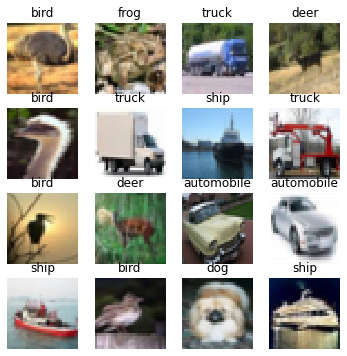

In [5]:
# Hide any GPUs from TensorFlow. Otherwise TF might reserve memory and make
# it unavailable to JAX.
tf.config.experimental.set_visible_devices([], 'GPU')

train_ds, ds_info = load_dataset("train", is_training=True,
                                  batch_size=FLAGS.train_batch_size)
test_ds, _ = load_dataset("test", is_training=False,
                          batch_size=FLAGS.test_batch_size)
input_shape = (1,) + ds_info.features["image"].shape
num_classes = ds_info.features["label"].num_classes
iter_per_epoch_train = ds_info.splits['train'].num_examples // FLAGS.train_batch_size
iter_per_epoch_test = ds_info.splits['test'].num_examples // FLAGS.test_batch_size


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
mb_images, mb_labels = next(train_ds)
_, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6))
for i in range(4):
  for j in range(4):
    k = i * 4 + j
    axes[i, j].imshow(mb_images[k], cmap=plt.cm.gray_r, interpolation="nearest")
    axes[i, j].set_axis_off()
    axes[i, j].set_title(class_names[mb_labels[k]])

In [6]:
# Set up model.
if FLAGS.model == "resnet1":
  net = ResNet1(num_classes=num_classes)
elif FLAGS.model == "resnet18":
  net = ResNet18(num_classes=num_classes)
elif FLAGS.model == "resnet34":
  net = ResNet34(num_classes=num_classes)
else:
  raise ValueError("Unknown model.")


def predict(params, inputs, batch_stats, train=False):
  x = inputs.astype(jnp.float32) / 255.
  all_params = {"params": params, "batch_stats": batch_stats}
  if train:
    # Returns logits and net_state (which contains the key "batch_stats").
    return net.apply(all_params, x, train=train, mutable=["batch_stats"])
  else:
    # Returns logits only.
    return net.apply(all_params, x, train=train, mutable=False)

logistic_loss = jax.vmap(loss.multiclass_logistic_loss)


def loss_from_logits(params, l2reg, logits, labels):
  mean_loss = jnp.mean(logistic_loss(labels, logits))
  sqnorm = tree_util.tree_l2_norm(params, squared=True)
  return mean_loss + 0.5 * l2reg * sqnorm


@jax.jit
def accuracy_and_loss(params, l2reg, data, aux):
  inputs, labels = data
  logits = predict(params, inputs, aux, train=False)
  accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
  loss = loss_from_logits(params, l2reg, logits, labels)
  return accuracy, loss


def loss_fun(params, l2reg, data, aux):
  inputs, labels = data
  logits, net_state = predict(params, inputs, aux, train=True)
  loss = loss_from_logits(params, l2reg, logits, labels)
  # batch_stats will be stored in state.aux
  return loss, net_state["batch_stats"]

In [7]:
# Initialize solver.
opt = optax.adam(learning_rate=FLAGS.learning_rate)

# We need has_aux=True because loss_fun returns batch_stats.
solver = OptaxSolver(opt=opt, fun=loss_fun,
                     maxiter=FLAGS.epochs * iter_per_epoch_train, has_aux=True)

# Initialize parameters.
rng = jax.random.PRNGKey(0)
init_vars = net.init({"params": rng}, jnp.ones(input_shape, net.dtype))
params = init_vars["params"]
batch_stats = init_vars["batch_stats"]
start = datetime.now().replace(microsecond=0)

# Run training loop.
state = solver.init_state(params)
jitted_update = jax.jit(solver.update)

all_test_error = []
all_train_loss = []
for it in range(solver.maxiter):
  train_minibatch = next(train_ds)

  if state.iter_num % iter_per_epoch_train == iter_per_epoch_train - 1:
    # Once per epoch evaluate the model on the train and test sets.
    test_acc, test_loss = 0., 0.
    # make a pass over test set to compute test accuracy
    for _ in range(iter_per_epoch_test):
        tmp = accuracy_and_loss(params, FLAGS.l2reg, next(test_ds), batch_stats)
        test_acc += tmp[0] / iter_per_epoch_test
        test_loss += tmp[1] / iter_per_epoch_test

    train_acc, train_loss = 0., 0.
    # make a pass over train set to compute train accuracy
    for _ in range(iter_per_epoch_train):
        tmp = accuracy_and_loss(params, FLAGS.l2reg, next(train_ds), batch_stats)
        train_acc += tmp[0] / iter_per_epoch_train
        train_loss += tmp[1] / iter_per_epoch_train

    train_acc = jax.device_get(train_acc)
    train_loss = jax.device_get(train_loss)
    test_acc = jax.device_get(test_acc)
    test_loss = jax.device_get(test_loss)
    all_test_error.append(1 - test_acc)
    all_train_loss.append(train_loss)
    # time elapsed without microseconds
    time_elapsed = (datetime.now().replace(microsecond=0) - start)

    print(f"[Epoch {state.iter_num // (iter_per_epoch_train+1) + 1}/{FLAGS.epochs}] "
          f"Train acc: {train_acc:.3f}, train loss: {train_loss:.3f}. "
          f"Test acc: {test_acc:.3f}, test loss: {test_loss:.3f}. "
          f"Time elapsed: {time_elapsed}")


  params, state = jitted_update(params=params,
                                state=state,
                                l2reg=FLAGS.l2reg,
                                data=train_minibatch,
                                aux=batch_stats)
  batch_stats = state.aux

[Epoch 1/50] Train acc: 0.546, train loss: 1.496. Test acc: 0.527, test loss: 1.553. Time elapsed: 0:00:28
[Epoch 2/50] Train acc: 0.591, train loss: 1.377. Test acc: 0.553, test loss: 1.506. Time elapsed: 0:00:32
[Epoch 3/50] Train acc: 0.559, train loss: 1.515. Test acc: 0.523, test loss: 1.692. Time elapsed: 0:00:36
[Epoch 4/50] Train acc: 0.609, train loss: 1.472. Test acc: 0.556, test loss: 1.722. Time elapsed: 0:00:40
[Epoch 5/50] Train acc: 0.694, train loss: 1.153. Test acc: 0.607, test loss: 1.522. Time elapsed: 0:00:43
[Epoch 6/50] Train acc: 0.801, train loss: 0.795. Test acc: 0.675, test loss: 1.274. Time elapsed: 0:00:47
[Epoch 7/50] Train acc: 0.807, train loss: 0.802. Test acc: 0.665, test loss: 1.385. Time elapsed: 0:00:51
[Epoch 8/50] Train acc: 0.736, train loss: 1.044. Test acc: 0.612, test loss: 1.688. Time elapsed: 0:00:54
[Epoch 9/50] Train acc: 0.830, train loss: 0.767. Test acc: 0.662, test loss: 1.560. Time elapsed: 0:00:58
[Epoch 10/50] Train acc: 0.686, train

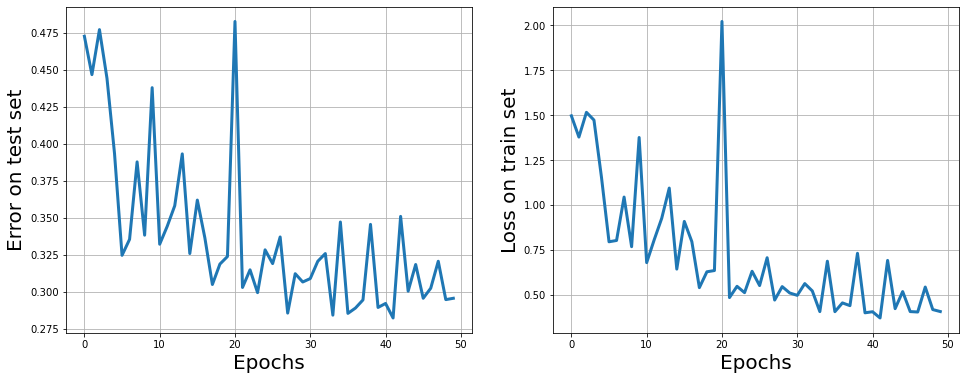

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(all_test_error, lw=3)
ax1.set_ylabel('Error on test set', fontsize=20)
ax1.grid()
ax1.set_xlabel('Epochs', fontsize=20)

ax2.plot(all_train_loss, lw=3)
ax2.set_ylabel('Loss on train set', fontsize=20)
ax2.grid()
ax2.set_xlabel('Epochs', fontsize=20)

plt.show()